# Spatial joins

Goals of this notebook:

- Based on the `countries` and `cities` dataframes, determine for each city the country in which it is located.
- To solve this problem, we will use the the concept of a 'spatial join' operation: combining information of geospatial datasets based on their spatial relationship.

In [4]:
%matplotlib inline

import pandas as pd
import geopandas
import os

pd.options.display.max_rows = 10

In [2]:
from pathlib import Path
path_folder = Path("/Users/keithlowton/Desktop/Ks/Python code/Geospatial data")
print(path_folder.exists())
print(path_folder)

True
/Users/keithlowton/Desktop/Ks/Python code/Geospatial data


In [5]:
countries = geopandas.read_file(os.path.join(path_folder, "ne_110m_admin_0_countries.zip"))
cities = geopandas.read_file(os.path.join(path_folder, "ne_110m_populated_places.zip"))
rivers = geopandas.read_file(os.path.join(path_folder, "ne_50m_rivers_lake_centerlines.zip"))

## Recap - joining dataframes

Pandas provides functionality to join or merge dataframes in different ways, see https://chrisalbon.com/python/data_wrangling/pandas_join_merge_dataframe/ for an overview and https://pandas.pydata.org/pandas-docs/stable/merging.html for the full documentation.

To illustrate the concept of joining the information of two dataframes with pandas, let's take a small subset of our `cities` and `countries` datasets: 

In [6]:
cities2 = cities[cities['name'].isin(['Bern', 'Brussels', 'London', 'Paris'])].copy()
cities2['iso_a3'] = ['CHE', 'BEL', 'GBR', 'FRA']

In [7]:
cities2

,name,geometry,iso_a3
26,Bern,POINT (7.46698 46.91668),CHE
170,Brussels,POINT (4.33137 50.83526),BEL
219,London,POINT (-0.11867 51.50194),GBR
235,Paris,POINT (2.33139 48.86864),FRA


In [8]:
countries2 = countries[['iso_a3', 'name', 'continent']]
countries2.head()

,iso_a3,name,continent
0,AFG,Afghanistan,Asia
1,AGO,Angola,Africa
2,ALB,Albania,Europe
3,ARE,United Arab Emirates,Asia
4,ARG,Argentina,South America


We added a 'iso_a3' column to the `cities` dataset, indicating a code of the country of the city. This country code is also present in the `countries` dataset, which allows us to merge those two dataframes based on the common column.

Joining the `cities` dataframe with `countries` will transfer extra information about the countries (the full name, the continent) to the `cities` dataframe, based on a common key:

In [9]:
cities2.merge(countries2, on='iso_a3')

,name_x,geometry,iso_a3,name_y,continent
0,Bern,POINT (7.46698 46.91668),CHE,Switzerland,Europe
1,Brussels,POINT (4.33137 50.83526),BEL,Belgium,Europe
2,London,POINT (-0.11867 51.50194),GBR,United Kingdom,Europe
3,Paris,POINT (2.33139 48.86864),FRA,France,Europe


**But**, for this illustrative example, we added the common column manually, it is not present in the original dataset. However, we can still know how to join those two datasets based on their spatial coordinates.

## Recap - spatial relationships between objects

In the previous notebook [02-spatial-relationships.ipynb](./02-spatial-relationships-operations.ipynb), we have seen the notion of spatial relationships between geometry objects: within, contains, intersects, ...

In this case, we know that each of the cities is located *within* one of the countries, or the other way around that each country can *contain* multiple cities.

We can test such relationships using the methods we have seen in the previous notebook:

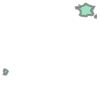

In [10]:
france = countries.loc[countries['name'] == 'France', 'geometry'].squeeze()
france

In [11]:
cities.within(france)

0      False
1      False
2      False
3      False
4      False
       ...  
238    False
239    False
240    False
241    False
242    False
Length: 243, dtype: bool

The above gives us a boolean series, indicating for each point in our `cities` dataframe whether it is located within the area of France or not.  
Because this is a boolean series as result, we can use it to filter the original dataframe to only show those cities that are actually within France:

In [12]:
cities[cities.within(france)]

,name,geometry
10,Monaco,POINT (7.40691 43.73965)
13,Andorra,POINT (1.51649 42.50000)
186,Geneva,POINT (6.14003 46.21001)
235,Paris,POINT (2.33139 48.86864)


We could now repeat the above analysis for each of the countries, and add a column to the `cities` dataframe indicating this country. However, that would be tedious to do manually, and is also exactly what the spatial join operation provides us.

*(note: the above result is incorrect, but this is just because of the coarse-ness of the countries dataset)*

## Spatial join operation

<div class="alert alert-info" style="font-size:120%">
<b>SPATIAL JOIN</b> = *transferring attributes from one layer to another based on their spatial relationship* <br><br>


Different parts of this operations:

<ul>
  <li>The GeoDataFrame to which we want add information</li>
  <li>The GeoDataFrame that contains the information we want to add </li>
  <li>The spatial relationship we want to use to match both datasets ('intersects', 'contains', 'within')</li>
  <li>The type of join: left or inner join</li>
</ul>

</div>

In this case, we want to join the `cities` dataframe with the information of the `countries` dataframe, based on the spatial relationship between both datasets.

We use the [`geopandas.sjoin`](http://geopandas.readthedocs.io/en/latest/reference/geopandas.sjoin.html) function:

In [13]:
joined = geopandas.sjoin(cities, countries, op='within', how='left')

/Users/keithlowton/anaconda3/envs/Geospatial/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [14]:
joined

,name_left,geometry,index_right,iso_a3,name_right,continent,pop_est,gdp_md_est
0,Vatican City,POINT (12.45339 41.90328),79.0,ITA,Italy,Europe,6.213780e+07,2221000.0
1,San Marino,POINT (12.44177 43.93610),79.0,ITA,Italy,Europe,6.213780e+07,2221000.0
2,Vaduz,POINT (9.51667 47.13372),9.0,AUT,Austria,Europe,8.754413e+06,416600.0
3,Lobamba,POINT (31.20000 -26.46667),152.0,SWZ,Swaziland,Africa,1.467152e+06,11060.0
4,Luxembourg,POINT (6.13000 49.61166),97.0,LUX,Luxembourg,Europe,5.941300e+05,58740.0
...,...,...,...,...,...,...,...,...
238,Rio de Janeiro,POINT (-43.22697 -22.92308),22.0,BRA,Brazil,South America,2.073534e+08,3081000.0
239,São Paulo,POINT (-46.62697 -23.55673),22.0,BRA,Brazil,South America,2.073534e+08,3081000.0
240,Sydney,POINT (151.18323 -33.91807),8.0,AUS,Australia,Oceania,2.323241e+07,1189000.0
241,Singapore,POINT (103.85387 1.29498),111.0,MYS,Malaysia,Asia,3.138199e+07,863000.0


In [15]:
joined['continent'].value_counts()

continent
Asia             59
Africa           57
Europe           46
North America    26
South America    14
Oceania           8
Name: count, dtype: int64

## The overlay operation

In the spatial join operation above, we are not changing the geometries itself. We are not joining geometries, but joining attributes based on a spatial relationship between the geometries. This also means that the geometries need to at least overlap partially.

If you want to create new geometries based on joining (combining) geometries of different dataframes into one new dataframe (eg by taking the intersection of the geometries), you want an **overlay** operation.

In [16]:
africa = countries[countries['continent'] == 'Africa']

<Axes: >

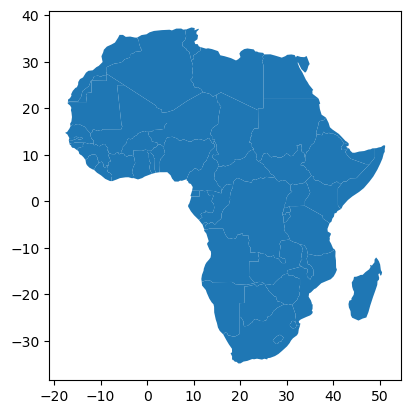

In [17]:
africa.plot()

In [18]:
cities['geometry'] = cities.buffer(2)

/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_2845/1163649495.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cities['geometry'] = cities.buffer(2)


<Axes: >

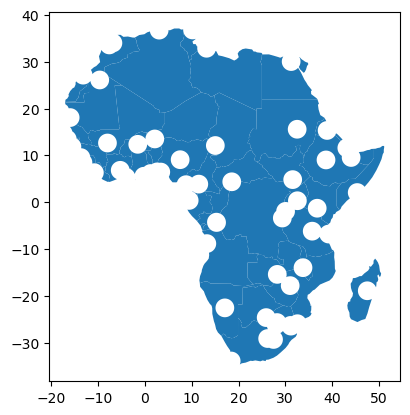

In [19]:
geopandas.overlay(africa, cities, how='difference').plot()

<div class="alert alert-info" style="font-size:120%">
<b>REMEMBER</b> <br>

<ul>
  <li>**Spatial join**: transfer attributes from one dataframe to another based on the spatial relationship</li>
  <li>**Spatial overlay**: construct new geometries based on spatial operation between both dataframes (and combining attributes of both dataframes)</li>
</ul>

</div>